# RNN Based molucule generation

Laurent Cetinsoy

In this hands-on we want to generate molecule formulas for denovo-drug discovery.

For that we need to use Generative models. Generative models are models which goes beyond classification or simple regression : they are able to generate data that look like previously seens dataset.

There exists a lot of models :

- Bayesian models like graphical models
- Recurrent models (for sequence generation like texte)
- Variational auto encoders
- Generative adversarial models
- Flow and diffusion models


In the hands-on we will start by  trainning a character based RNN to generate smile molecules


We want to feed smile representations of molecules to an RNN.
The basic idea is we will train it to predict the next smile token of a molecule given the previous one.

For instance for the following molecule "CC(=O)NC1=CC=C(O)C=C1" will may give to the model

X = "CC(=O)N"
y = C

and ask the RNN to learn to predict y given X

Like a standard language model !


## RNN Language model


A language model is a model which predict the next token of a sequence given the previous ones :

$ P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p})  $


This model can be learned with a Recurrent neural network

$ y = P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p}) = RNN_{\theta} (X_{t-1}, X_{t-2}, ..., X_{t-p})  $


In order to train such model you need a corpus of data.



There are two main ways to do that : Word level model or character level model

For character level models, an interesting resource is : http://karpathy.github.io/2015/05/21/rnn-effectiveness/



Explain briefly what is the difference between word based language model and character based language model

Word based language models generate text one word at a time. They are typically good to generate coherent text. On the other hand, character based models operate on character level and thus don't need to rely on a predefined vocabulary. This makes them more flexible but they tend to generate less coherent text.

## Loading the data

Dowload the following dataset : https://github.com/joeymach/Leveraging-VAE-to-generate-molecules

Import pandas and load the first 1000 lines

In [8]:
import pandas as pd

df = pd.read_csv('active_data.csv', nrows=1_000)

(379, 3)

Display the first rows of the dataframe

In [38]:
df.iloc[0]

SMILES       Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...
ID                                                      168691
is_active                                                    1
Name: 0, dtype: object

## Processing the data

We need to do the following things :

- convert smile tokens to numbers
- build  smile token sequences and corresponding labels pairs

Compute the biggest smile molecule size

In [35]:
biggest = df['SMILES'].str.len().max()
biggest

92


Code a function **unic_characters(string)** which return the unique characters in a string


In [12]:
import numpy as np

def unic_characters(string: str):
    return np.unique(list(string))

Concatenate all smile string of the pandas dataframe and use **unic_characters** to get the unic_characters

In [14]:
all_smiles = df['SMILES'].str.cat()
unique_characters = unic_characters(all_smiles)
unique_characters

array(['#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '6', '7',
       '8', '=', '@', 'B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[',
       '\\', ']', 'c', 'l', 'n', 'o', 'r', 's'], dtype='<U1')

Code a function **map_char_to_int(unic_chars)** which returns a dictionnary where each char is assigned an int value.
Add a character to specify the end of the molecule (like "\n")


In [15]:
END_TOKEN = '\n'

In [16]:
def map_char_to_int(unic_chars) -> dict[str, int]:
    mapping = {c: i for i, c in enumerate(unic_chars)}
    mapping[END_TOKEN] = len(mapping)
    return mapping

Code a function map_int_to_char(unic_chars) which returns the reverse mapping.

If you want you can merge both functions in a class

In [17]:
class CharMapper:
    def __init__(self, unique_chars: set[str]):
        self._mapping = map_char_to_int(unique_chars)
        self._reverse_mapping = {v: k for k, v in self._mapping.items()}

    def __len__(self) -> int:
        return len(self._mapping)

    def char_to_int(self, string: str) -> list[int]:
        return [self._mapping[char] for char in string]

    def int_to_char(self, integers: int | list[int]) -> str:
        if isinstance(integers, int):
            return self._reverse_mapping[integers]
        return ''.join([self._reverse_mapping[i] for i in integers])

For each smile molecule add the ending token to it

In [18]:
df['SMILES'] = df['SMILES'].str.pad(width=biggest, side='right', fillchar=END_TOKEN)

'Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCCN5CCOCC5)OC\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

## Building the dataset

Now we will create the dataset so that it has the good share for our Keras LSTM model

Remember Keras recurrent models expect a 3D array with shapes (n_examples, seq_len, n_features)



What will be n_features in our case ?

In our case, `n_features` will be the number of unique characters in our dataset.

Code a function **build_X_and_y(string, i_char, seq_lenght)** which takes a string, a **seq_length** number and a position.


It should create X by by getting all character between i and i + seq_length
and create y by getting the character following the X sequence
it returns X and y

In [19]:
def build_X_and_y(string, i_char, seq_length):
    end_char = i_char + seq_length
    X = string[i_char:end_char]
    y = string[end_char]
    return X, y

Test your function on the following string "Lorem ipsum" with seq_length = 4 and i = [1, 2, 3]

In [20]:
string = 'Lorem ipsum'
for i in (1, 2, 3):
    X, y = build_X_and_y(string, i, 4)
    print(f"X: {X} -> y: '{y}'")

X: orem -> y: ' '
X: rem  -> y: 'i'
X: em i -> y: 'p'


By using build_X_and_y and map_char_to_int build a list nameed X_train and a list named y_train

In [22]:
SEQUENCE_LENGTH = 10
mapper = CharMapper(unique_characters)

X_train = []
y_train = []

for smiles in df['SMILES']:
    for i in range(len(smiles) - SEQUENCE_LENGTH):
        X, y = build_X_and_y(smiles, i, SEQUENCE_LENGTH)
        if X.endswith(END_TOKEN):
            break
        X_train.append(mapper.char_to_int(X))
        y_train.append(mapper.char_to_int(y))

Create numpy arrays from the lists

In [34]:
from keras.utils import to_categorical

X_train = np.array(X_train)
y_train = to_categorical(y_train, num_classes=len(mapper) + 1)

Reshape the X numpy array (n_examples, seq_lenght, 1)

In [24]:
X_train = X_train.reshape(-1, SEQUENCE_LENGTH, 1)
X_train.shape

(16318, 10, 1)

Normalize X by dividing each values by the total number of unic characters

In [25]:
X_train_normalized = X_train / len(mapper)

Import Keras and build (at least) a two layered LSTM network with 128 neurone in each.

You can also add Dropoutlayers

Do you think you should use the return_sequences = True ? If yes, when ?


Add a Dense layer on top with with the appropriate activation function and number of neurones


In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(256, return_sequences=True),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax'),
])

Compile the model with the appropriate loss function and the adam optimizer

In [27]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 256)           264192    
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 10, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 36)                9

Train the model on 20 epochs and 10 examples (yeah you read correctly) and check that the model overfits !

Epoch 1/20
1/1 [==============================] - 0s 193ms/step - loss: 1.3242 - val_loss: 2.8430
Epoch 2/20
1/1 [==============================] - 0s 232ms/step - loss: 1.2508 - val_loss: 2.9863
Epoch 3/20
1/1 [==============================] - 0s 239ms/step - loss: 1.2473 - val_loss: 3.2425
Epoch 4/20
1/1 [==============================] - 0s 198ms/step - loss: 1.1780 - val_loss: 3.5961
Epoch 5/20
1/1 [==============================] - 0s 260ms/step - loss: 1.1246 - val_loss: 4.0199
Epoch 6/20
1/1 [==============================] - 0s 214ms/step - loss: 1.0938 - val_loss: 4.4552
Epoch 7/20
1/1 [==============================] - 0s 170ms/step - loss: 0.9675 - val_loss: 4.8868
Epoch 8/20
1/1 [==============================] - 0s 325ms/step - loss: 1.0324 - val_loss: 5.3053
Epoch 9/20
1/1 [==============================] - 0s 236ms/step - loss: 1.0158 - val_loss: 5.6713
Epoch 10/20
1/1 [==============================] - 0s 212ms/step - loss: 0.8947 - val_loss: 5.9774
Epoch 11/20
1/1 [==

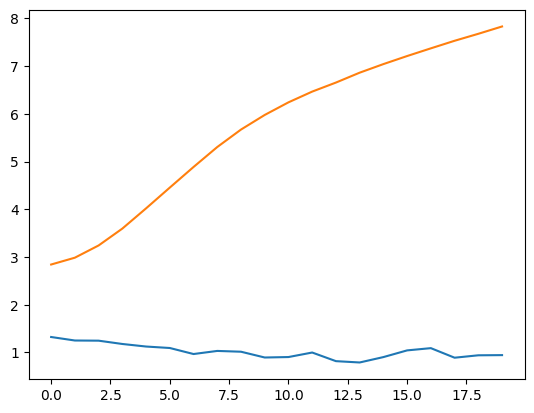

In [29]:
import matplotlib.pyplot as plt

N_EXAMPLES = 10

model.fit(
    x=X_train_normalized[:N_EXAMPLES],
    y=y_train[:N_EXAMPLES],
    epochs=20,
    validation_split=0.2,
)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.show()

The validation loss is well above the training loss at the end of the training. This is a clear sign of overfitting.

Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule


In [30]:
def make_prediction(seed_start, mapper, model, max_len = 100):
    prediction = None
    seed_start = seed_start.rjust(SEQUENCE_LENGTH, END_TOKEN)
    while prediction != END_TOKEN and len(seed_start) < max_len:
        X = np.array(mapper.char_to_int(seed_start)).reshape(1, -1, 1)
        X = X[:, -SEQUENCE_LENGTH::, :]
        X = X / len(mapper)
        y_pred = model(X)
        prediction = mapper.int_to_char([np.argmax(y_pred)])
        seed_start += prediction

    return seed_start.lstrip(END_TOKEN)

generate a molecule of your overfitted model

In [31]:
make_prediction('CC1=CC=CC=C1', mapper, model)

'CC1=CC=CC=C1cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc'

Make a model checkpoint so that the model is saved after each epoch
if you train on a plateform and it stops you do not lose your training

In [32]:
model.save('overfitted_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Now go to your favorite plateform (colab or something else) and train the dataset on the whole data for 10 epochs and batch size 256

it should take a long time so either follow the class or go take a nap

In [33]:
# First clear the model
model.reset_states()
model.fit(X_train_normalized, y_train, epochs=10, batch_size=256, validation_split=0.2)

Epoch 1/10
51/51 [==============================] - 31s 612ms/step - loss: 3.6405 - val_loss: 2.8948
Epoch 2/10
51/51 [==============================] - 30s 590ms/step - loss: 2.8367 - val_loss: 2.8849
Epoch 3/10
51/51 [==============================] - 31s 610ms/step - loss: 2.8327 - val_loss: 2.8915
Epoch 4/10
51/51 [==============================] - 31s 616ms/step - loss: 2.8312 - val_loss: 2.8893
Epoch 5/10
51/51 [==============================] - 30s 588ms/step - loss: 2.8273 - val_loss: 2.8949
Epoch 6/10
51/51 [==============================] - 30s 590ms/step - loss: 2.8176 - val_loss: 2.8877
Epoch 7/10
51/51 [==============================] - 31s 613ms/step - loss: 2.7813 - val_loss: 2.8283
Epoch 8/10
51/51 [==============================] - 30s 588ms/step - loss: 2.6867 - val_loss: 2.7185
Epoch 9/10
51/51 [==============================] - 30s 586ms/step - loss: 2.5542 - val_loss: 2.5701
Epoch 10/10
51/51 [==============================] - 31s 615ms/step - loss: 2.3464 - val_lo

Generate between 100 and 1000 molecules.

create a list where molecules have between 10 and 50 atoms

In [ ]:
prefixes = df['smiles'].str[:SEQUENCE_LENGTH].sample(100)
np.vectorize(make_prediction, excluded=(1, 2))(prefixes, mapper, model, max_len=50)

array(['COC(=C(C#N)CC1\n', 'CCN[C@H](c2ccccc2)CC1\n',
       'C[C@@H]([C@@H](C)C1\n', 'CCOc1ccc(NC(=O)c2ccc(Cl)cc2)CC1\n',
       'COc1cccc(OC(=O)c2ccc(Cl)cc2)CC1\n', 'CC(C)CN(C(C(C)CC1\n',
       'C[C@@H]1CCC[C@@H](C)C1\n', 'CCc1c(C(=O)N2CCCCCC2)c1\n',
       'Cc1cc(N)nc(CONC2](C)CC2)cc1\n', 'Cc1cccc(-c2ccccc2)CC1\n',
       'O=C(N1CCc2ccccc2C(=O)Nc1ccc(Cl)cc1\n',
       'Cc1nc(CNC(=O)NC(=O)c1ccc(Cl)cc1\n',
       'CCn1cc(C(=O)Nc2ccc(Cl)cc2)CC1\n', 'COc1cc([C@@H](C)C1\n',
       'COc1ccc(C(=O)Nc2ccc(Cl)cc2)CC1\n',
       'Cc1cccn2c(=O)c(C(c(=O)n(C)c(=O)n(C)c(=O)n(C)c(=O)n',
       'Cn1cc(C(=O)Nc2ccc(Cl)cc2)CC1\n', 'CN(C[C@@H](C)C1\n',
       'Clc1ccc([C@@H](C)C1\n', 'CS(=O)(=O)c1ccc(Cl)cc1\n',
       'COc1cc([N+](=O)[O-])c2)CCCC1\n', 'O=C(C1CCCCC1\n',
       'C[C@@H]1CCC[C@@H](C)C1\n', 'O[C@H]1CCC[C@@H](C)C1\n',
       'CCN1CCC(=N)CC1CC2)CC1\n',
       'CCCc1cc(=O)n(C(c(=O)n(C)c(=O)n(C)c(=O)n(C)c(=O)n(C',
       'C[C@H](CC#=O)NCc2ccccc1NC(=O)[C@@H](C)C1\n',
       'CCOC(=O)c1ccc(Cl)cc

In [ ]:
prefixes = df['smiles'].sample(1000)

With rdkit compute the Quantified Estimated Drug likelyness (QED) of each molecule in this subset

Bonus 1 : Using rdkit, compute the quantitative estimation of drug-likeness (QED) of your generated molecules.

In [ ]:
prefixes.iloc[0]

'COC1CC[NH+](Cn2nc(-c3ccc(C)cc3)n(C)c2=S)CC1\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

Bonus 2 : try to adapt a transformer model training from hugging face to see if it is better